# Counting analysis

In [123]:
import glob, re, getpass, collections, operator, scipy.stats, sklearn.metrics
from itertools import chain
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from functions.bhsa import get_data, unique, lbh_books, sbh_books # <- here's the new data data load statement -CK

from numpy.polynomial import Polynomial
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import pearsonr 


In [96]:
all_data = get_data()

## Analysis Functions

In [152]:
def make_counts(feature_dict):
    '''
    Return a dictionary with frequency counts of the feature values.
    Requires a feature dict: feature[book] = list(list()*N)
    '''
    
    feature_count = dict() # counts here

    # loop and count
    for bookname, units in feature_dict.items():
        feature_count[bookname] = collections.Counter(list(chain(*units))) 

    # make into dataframe
    df_Count = pd.DataFrame(feature_count, columns=feature_dict.keys()).fillna(0)
    df_Prob = df_Count.div(df_Count.sum(axis=0), axis=1)
    
    # return both count and probability objects
    return  df_Count, df_Prob

def chi_squareTest(matrix):
    '''
    Perform a chi-squared test on any matrix and return the p value.
    '''
    chi2, p, dof, ex = scipy.stats.chi2_contingency(matrix)
    return p

def plot_occurences(df, books):
    '''
    Plot linear regression line.
    '''
    n = len(books)
    plt.close('all')
    f, axarr = plt.subplots(n, n,figsize=(25,25))
    for indexi,i in enumerate(books):
        for indexj,j in enumerate(books):
            x = np.array(df[i].values)
            y = np.array(df[j].values)
            p = Polynomial.fit(x, y, 1)
            if(indexj<=indexi):
                axarr[indexj, indexi].plot(x,y, 'ro')
                axarr[indexj, indexi].plot(*p.linspace(), color='blue')
                axarr[indexj, indexi].axes.xaxis.set_ticklabels([])
                axarr[indexj, indexi].axes.yaxis.set_ticklabels([])
                if(indexj==indexi):
                    axarr[indexj, indexi].set_xlabel(i,fontsize=18)
                    axarr[indexj, indexi].set_ylabel(j,fontsize=18)
            else:
                axarr[indexj, indexi].axis('off')
    plt.show() 
         
def linear_model_count(df, books):
    '''
    Compute the MSE of the linear regression and the 1-score. This is a distance measure between the linear regressions.
    '''
    df_MSE = pd.DataFrame(np.zeros((len(books), len(books))), columns = books, index = books) #Mean Square Error dataframe
    df_Score = pd.DataFrame(np.zeros((len(books), len(books))), columns = books, index = books) #Score data frame
    df_P = pd.DataFrame(np.zeros((len(books), len(books))), columns = books, index = books) #Score data frame
    
    for indexi,i in enumerate(books):
        for indexj,j in enumerate(books):
            x = np.matrix(df[i].values).transpose() #X matrix
            y = np.array(df[j].values) #Y vector
            
            regr = linear_model.LinearRegression(fit_intercept = True) #Note, we take the intercept. Usefull for symmetry of distance.
            regr.fit(x,y) #Fit the model
            
            df_Score.loc[i,j] = 1-regr.score(x,y) #Score 
            df_MSE.loc[i,j] = round(mean_squared_error(regr.predict(x), y),2) #MSE
            
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.array(df[i].values),y)
            df_P.loc[i,j] = round(p_value,3)
            
    return df_MSE,df_Score, df_P

def correlation_Spear(df, books):
    df_Cor = pd.DataFrame(np.zeros((len(books), len(books))), columns = books, index = books) 
    for indexi,i in enumerate(books):
        for indexj,j in enumerate(books):
            x = np.array(df[i].values) #X vector
            y = np.array(df[j].values) #Y vector

            c, statistic = pearsonr(x,y)
            df_Cor.loc[i,j] = 1-c
    return df_Cor

def hierarchical_clustering(distanceMatrix, method):
    '''
    Compute hierarchical clustering. Methods are single,complete,average,weighted, centroid, ward.
    https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html
    '''
    Z = linkage(distanceMatrix,  method)
    plt.figure(figsize=(25, 10))
    dendrogram(Z, labels = list(data.keys()))
    plt.show()
    

## Phrase function

In [189]:
data = all_data['phrase_functions']
unique_functions = unique(otype='phrase', feature='function') 
print(unique_functions)
df_Count, df_Prob = make_counts(data)
df_Count

['Pred', 'Conj', 'Subj', 'Cmpl', 'Objc', 'PreC', 'Adju', 'Rela', 'Nega', 'PreO', 'Time', 'Modi', 'Loca', 'Intj', 'Voct', 'Ques', 'Frnt', 'PreS', 'NCop', 'IntS', 'PrAd', 'Supp', 'PtcO', 'Exst', 'NCoS', 'ModS', 'EPPr', 'ExsS', 'PrcS']


,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Adju,173.0,1136,168.0,19.0,59.0,115.0,99.0,76.0,103.0,169.0,155.0,60.0,842,79.0,84.0,243.0,376.0
Cmpl,1252.0,6877,563.0,155.0,222.0,665.0,805.0,899.0,746.0,752.0,818.0,211.0,1895,109.0,288.0,416.0,871.0
Conj,2621.0,12890,1211.0,219.0,338.0,988.0,1426.0,1778.0,1388.0,1422.0,1499.0,288.0,3407,189.0,525.0,837.0,1568.0
Exst,4.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1.0,3.0,0.0,0.0
Frnt,14.0,100,12.0,0.0,0.0,10.0,5.0,9.0,9.0,28.0,13.0,1.0,37,2.0,2.0,10.0,22.0
IntS,1.0,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,12,0.0,0.0,2.0,10.0
Intj,42.0,141,12.0,1.0,2.0,3.0,18.0,20.0,12.0,15.0,16.0,0.0,7,0.0,1.0,0.0,6.0
Loca,120.0,663,122.0,8.0,25.0,55.0,57.0,61.0,56.0,79.0,80.0,11.0,214,17.0,53.0,41.0,92.0
ModS,4.0,11,0.0,0.0,0.0,0.0,2.0,1.0,1.0,3.0,0.0,1.0,1,0.0,0.0,0.0,0.0
Modi,86.0,408,52.0,8.0,9.0,36.0,37.0,49.0,51.0,45.0,35.0,8.0,98,7.0,19.0,24.0,40.0


As can be seen in the upper table, there are a lot of values < 5. Therefore, we cannot perform a chi-square test to compare the frequencies of phrase functions. What we would expect is that if two books are similar, then there would exist a linear relation between the frequencies of book A and book B. We would thus expect that every frequency from book A would be the same as c times the frequency of book B. In math: A = c * B where c is a positive number. Therefore, we expect a linear relation. We can perform linear regression on each two books A and B based on frequencies.

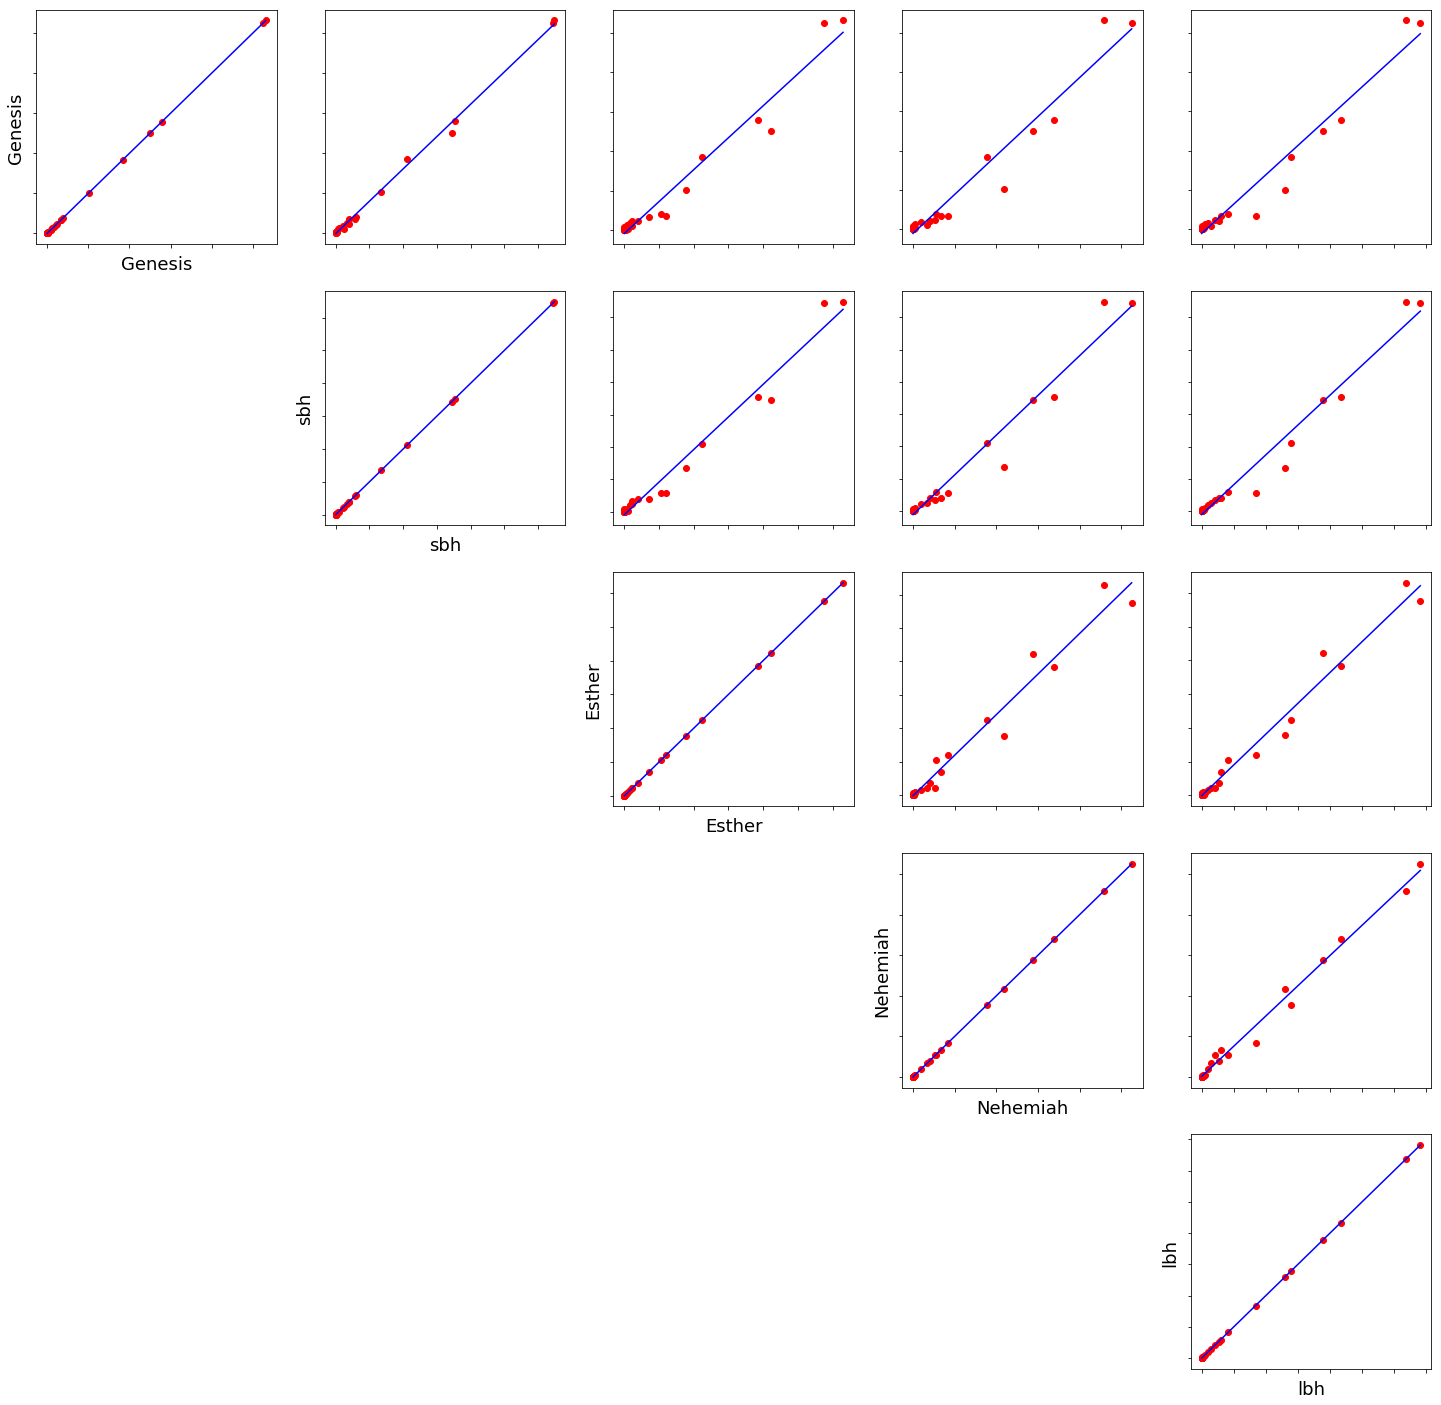

In [190]:
plot_occurences(df_Count, ["Genesis","sbh","Esther","Nehemiah", "lbh"])
#When plotting the frequencies of the same book, we expect the points on one line.
#We expect there is  direct linear relation between sbh and Genesis. All points should be on one line.
#We expect there is no direct linear relation between Esther and Genesis. So not all points are on one line.

Now, we can compute the Mean Square Error of the linear regression and the score. This score can serve as a distance between linear regression models

In [191]:
df_MSE,df_Score,df_P = linear_model_count(df_Count,data.keys())
df_Score

,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Genesis,0.000000,0.002546,0.010815,0.028503,0.036286,0.025790,0.007218,0.011204,0.010326,0.009296,0.011162,0.034887,0.038860,0.166926,0.045834,0.100524,0.023792
sbh,0.002546,0.000000,0.014470,0.027137,0.031330,0.013760,0.002750,0.007413,0.005071,0.005133,0.008950,0.022660,0.030788,0.156346,0.036073,0.091037,0.018675
Exodus,0.010815,0.014470,0.000000,0.032043,0.042241,0.036096,0.026927,0.029471,0.029260,0.017437,0.029148,0.039757,0.028908,0.132391,0.043461,0.078539,0.019297
Leviticus,0.028503,0.027137,0.032043,0.000000,0.020834,0.040834,0.028660,0.049584,0.042299,0.042305,0.026674,0.037862,0.069786,0.211223,0.092667,0.151982,0.039735
Deuteronomy,0.036286,0.031330,0.042241,0.020834,0.000000,0.043817,0.029853,0.061932,0.051097,0.041713,0.016879,0.040373,0.065433,0.214115,0.088206,0.158626,0.026597
Joshua,0.025790,0.013760,0.036096,0.040834,0.043817,0.000000,0.014273,0.020378,0.016376,0.011998,0.029392,0.008728,0.020004,0.121490,0.019638,0.068486,0.021197
Judges,0.007218,0.002750,0.026927,0.028660,0.029853,0.014273,0.000000,0.008864,0.005174,0.011826,0.008172,0.026343,0.041672,0.180712,0.043867,0.109290,0.025286
1_Samuel,0.011204,0.007413,0.029471,0.049584,0.061932,0.020378,0.008864,0.000000,0.001362,0.014488,0.026543,0.036737,0.043416,0.166281,0.038248,0.090702,0.041716
2_Samuel,0.010326,0.005071,0.029260,0.042299,0.051097,0.016376,0.005174,0.001362,0.000000,0.012610,0.019717,0.029796,0.040930,0.167984,0.039300,0.094064,0.035120
1_Kings,0.009296,0.005133,0.017437,0.042305,0.041713,0.011998,0.011826,0.014488,0.012610,0.000000,0.016085,0.017504,0.018347,0.120473,0.023278,0.068207,0.014861


In [192]:
#Check symmetry of distance matrix
np.allclose(df_Score.values, df_Score.values.T, atol=1e-8)

True

We can not do hierarchical cluster. Available methods are single,complete,average,weighted, centroid, ward.

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


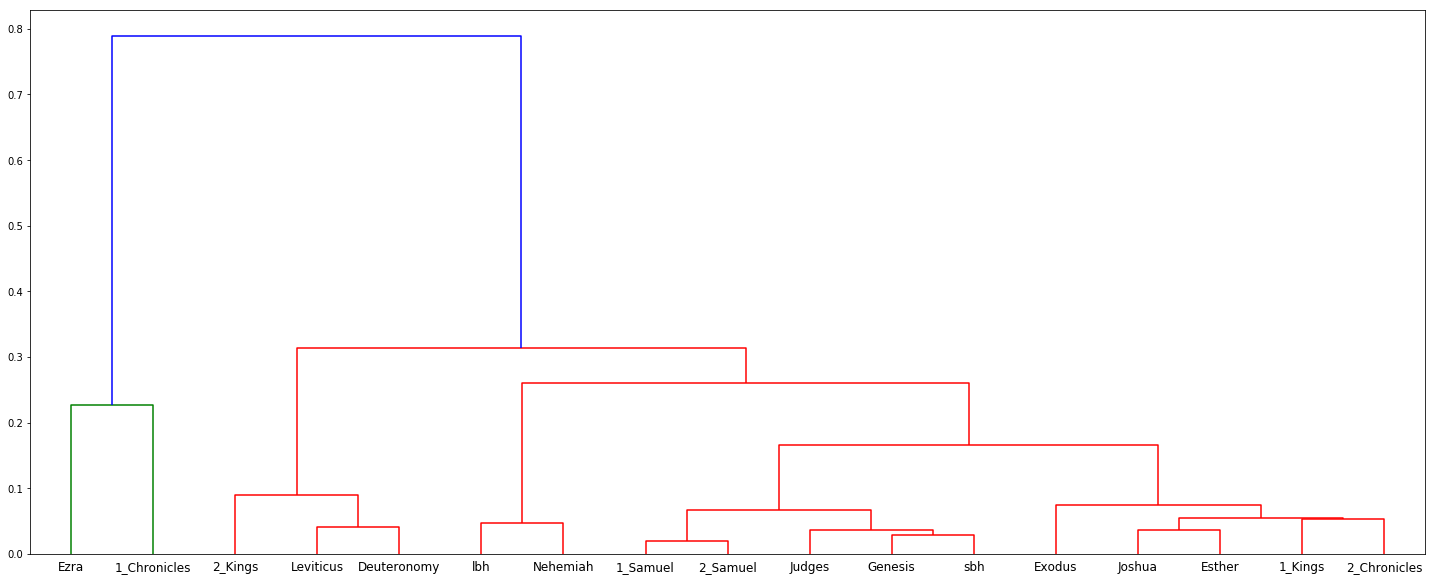

In [193]:
hierarchical_clustering(np.matrix(df_Score.values), "ward")

Another method for the distance is looking at the spearman correlation. This assumes that the data is normally distributed (which is not true in this case) but it is nice to take a look at.

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


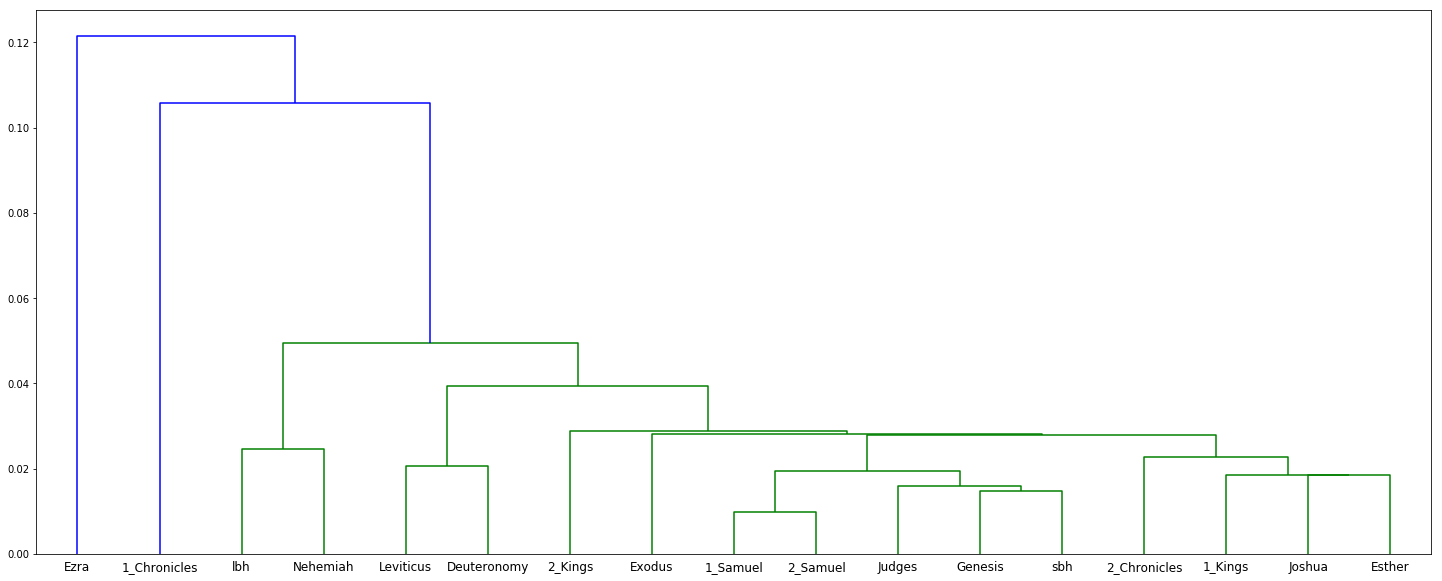

In [133]:
df_Cor = correlation_Spear(df_Count, data.keys())
hierarchical_clustering(np.matrix(df_Cor.values), "single")

# Phrase types

In [135]:
data = all_data['phrase_types']
unique_functions = unique(otype='phrase', feature='typ') 
print(unique_functions)
df_Count, df_Prob = make_counts(data)
df_Count

['VP', 'PP', 'CP', 'NP', 'PrNP', 'NegP', 'AdvP', 'PPrP', 'InjP', 'AdjP', 'InrP', 'IPrP', 'DPrP']


,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
AdjP,45,212,21.0,0.0,1.0,10.0,18,32.0,26.0,32.0,27.0,14.0,67,3.0,10,7.0,33.0
AdvP,225,923,81.0,13.0,23.0,88.0,98,115.0,108.0,88.0,84.0,10.0,188,15.0,26,53.0,84.0
CP,2819,14071,1293.0,233.0,386.0,1113.0,1536,1879.0,1477.0,1628.0,1707.0,341.0,3819,216.0,580,901.0,1781.0
DPrP,30,91,9.0,6.0,1.0,23.0,1,1.0,7.0,13.0,0.0,0.0,45,6.0,6,26.0,7.0
IPrP,1,5,2.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,2.0,4,0.0,2,0.0,0.0
InjP,43,145,12.0,1.0,2.0,4.0,18,20.0,12.0,16.0,17.0,0.0,19,0.0,1,2.0,16.0
InrP,2,18,0.0,0.0,1.0,0.0,2,0.0,0.0,8.0,5.0,3.0,7,0.0,1,1.0,2.0
NP,1195,6005,744.0,51.0,114.0,500.0,676,706.0,589.0,837.0,593.0,179.0,2420,281.0,421,584.0,955.0
NegP,60,539,60.0,1.0,37.0,49.0,67,65.0,40.0,75.0,85.0,16.0,166,8.0,40,21.0,81.0
PP,2188,12043,1266.0,285.0,444.0,1138.0,1315,1392.0,1167.0,1449.0,1399.0,387.0,3993,254.0,575,974.0,1803.0


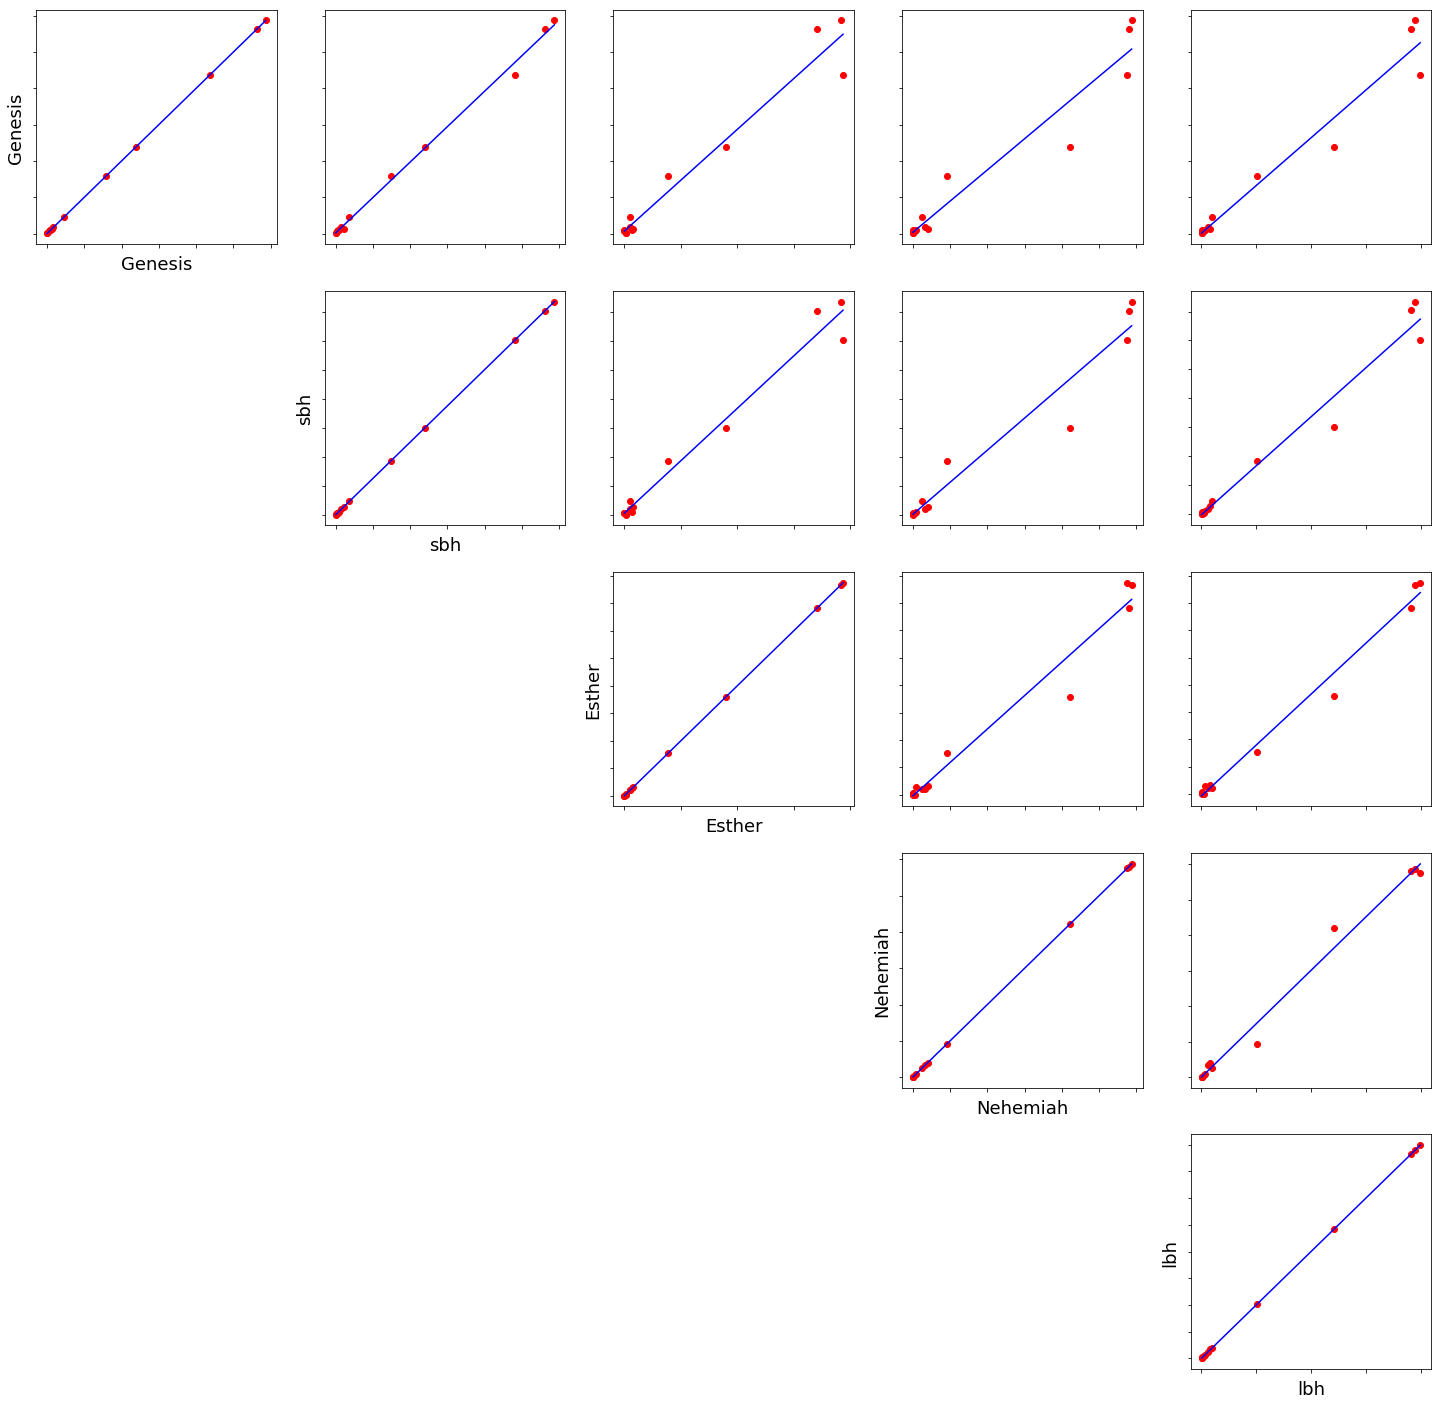

In [136]:
plot_occurences(df_Count, ["Genesis","sbh","Esther","Nehemiah", "lbh"])

In [137]:
df_MSE,df_Score, df_P = linear_model_count(df_Count,data.keys())
df_Score

,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Genesis,0.000000,0.002994,0.022014,0.077344,0.050581,0.027933,0.008546,0.003561,0.001067,0.012341,0.007403,0.039950,0.040329,0.224900,0.060282,0.074334,0.026814
sbh,0.002994,0.000000,0.012320,0.059689,0.033422,0.014689,0.003491,0.008955,0.003316,0.005968,0.005271,0.022415,0.026860,0.212109,0.047751,0.061855,0.013815
Exodus,0.022014,0.012320,0.000000,0.076286,0.046606,0.010948,0.011820,0.036289,0.024351,0.004228,0.029096,0.009463,0.003254,0.135404,0.015510,0.034457,0.002424
Leviticus,0.077344,0.059689,0.076286,0.000000,0.013533,0.038061,0.073633,0.075581,0.066685,0.081738,0.061955,0.049855,0.086455,0.334943,0.143601,0.094610,0.068234
Deuteronomy,0.050581,0.033422,0.046606,0.013533,0.000000,0.025735,0.037815,0.055352,0.044739,0.045541,0.030529,0.024691,0.059395,0.291659,0.098289,0.095141,0.036730
Joshua,0.027933,0.014689,0.010948,0.038061,0.025735,0.000000,0.019413,0.036119,0.025289,0.016925,0.029641,0.010892,0.014467,0.190455,0.043708,0.030545,0.010255
Judges,0.008546,0.003491,0.011820,0.073633,0.037815,0.019413,0.000000,0.020117,0.011753,0.002639,0.006101,0.019994,0.025530,0.201976,0.036878,0.075166,0.009750
1_Samuel,0.003561,0.008955,0.036289,0.075581,0.055352,0.036119,0.020117,0.000000,0.001652,0.026029,0.012194,0.055566,0.057225,0.258681,0.085079,0.080973,0.043110
2_Samuel,0.001067,0.003316,0.024351,0.066685,0.044739,0.025289,0.011753,0.001652,0.000000,0.016110,0.007929,0.040270,0.042816,0.237151,0.068562,0.070481,0.029373
1_Kings,0.012341,0.005968,0.004228,0.081738,0.045541,0.016925,0.002639,0.026029,0.016110,0.000000,0.014855,0.014855,0.013324,0.163983,0.021682,0.057846,0.004468


C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


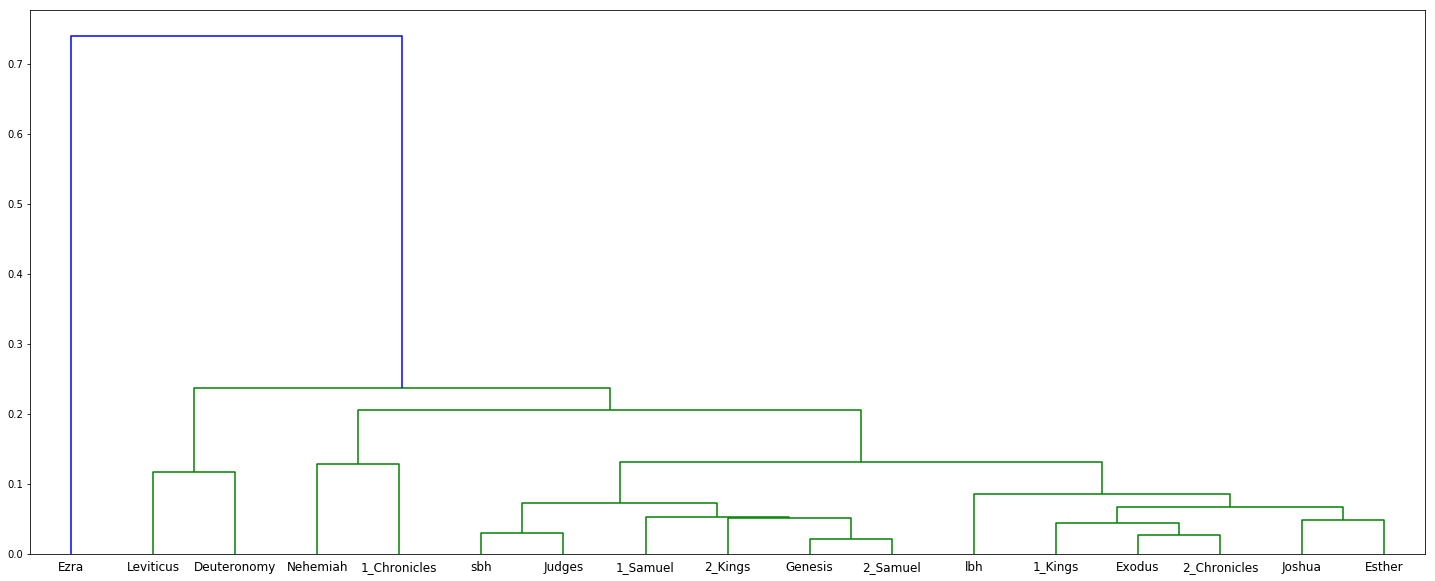

In [140]:
hierarchical_clustering(np.matrix(df_Score.values), "average")

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


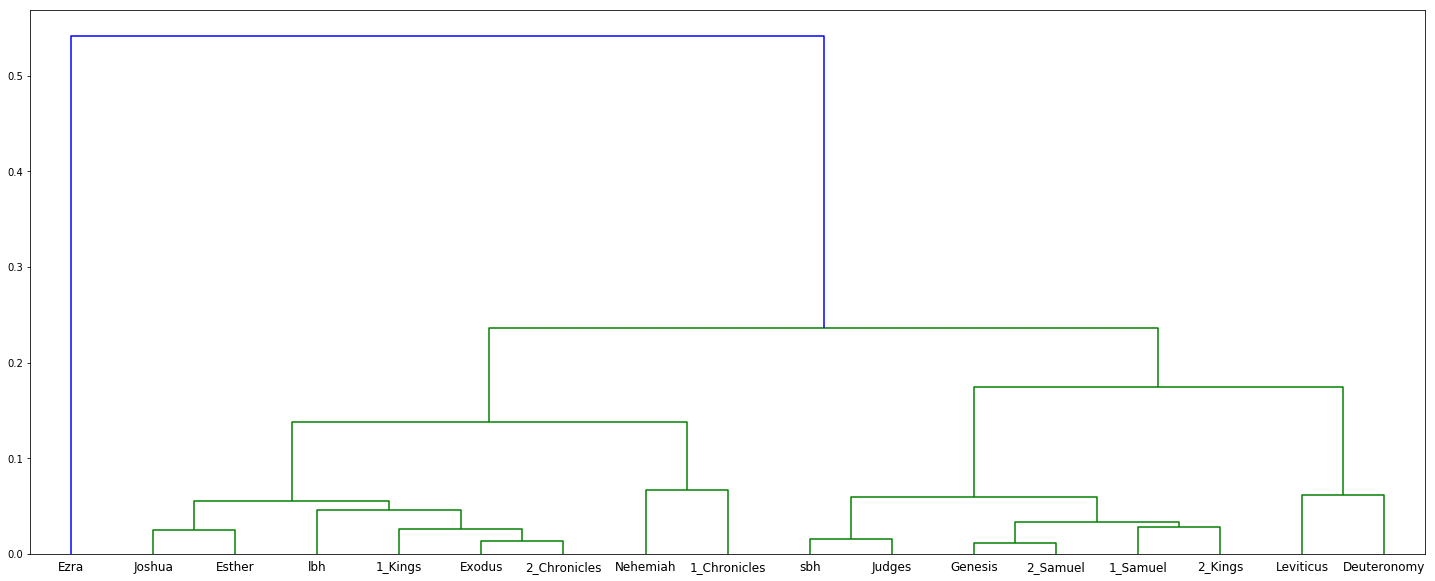

In [142]:
df_Cor = correlation_Spear(df_Count, data.keys())
hierarchical_clustering(np.matrix(df_Cor.values), "ward")

# Clause type


In [195]:
data = all_data['clause_types']
unique_functions = unique(otype='clause', feature='typ') 
print(unique_functions)
df_Count, df_Prob = make_counts(data)
df_Count

['NmCl', 'Way0', 'InfC', 'WayX', 'xYq0', 'Ptcp', 'WQt0', 'xQt0', 'ZIm0', 'xQtX', 'Ellp', 'WxY0', 'Voct', 'xYqX', 'WxQ0', 'XYqt', 'AjCl', 'XQtl', 'WXQt', 'WXYq', 'ZQt0', 'WQtX', 'CPen', 'ZYq0', 'WYq0', 'MSyn', 'WIm0', 'ZQtX', 'ZYqX', 'WxQX', 'WxYX', 'InfA', 'xIm0', 'WYqX', 'WxI0', 'WXIm', 'ZImX', 'XPos', 'XImp', 'Reop', 'WImX', 'xImX']


,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
AjCl,82.0,551.0,38.0,67.0,73.0,13.0,45.0,68.0,60.0,57.0,48.0,23.0,117.0,11.0,23.0,19.0,41.0
CPen,94.0,549.0,46.0,133.0,55.0,33.0,23.0,30.0,33.0,55.0,47.0,5.0,89.0,14.0,13.0,18.0,39.0
Ellp,118.0,818.0,190.0,69.0,95.0,84.0,31.0,38.0,70.0,78.0,45.0,31.0,533.0,46.0,145.0,185.0,126.0
InfA,3.0,66.0,7.0,3.0,16.0,12.0,2.0,10.0,3.0,2.0,8.0,14.0,33.0,1.0,7.0,4.0,7.0
InfC,435.0,3035.0,341.0,196.0,451.0,209.0,222.0,330.0,274.0,318.0,259.0,109.0,900.0,97.0,96.0,183.0,415.0
MSyn,33.0,280.0,32.0,3.0,29.0,19.0,26.0,47.0,30.0,29.0,32.0,0.0,64.0,12.0,6.0,19.0,27.0
NmCl,730.0,4041.0,498.0,423.0,295.0,353.0,261.0,420.0,344.0,416.0,301.0,74.0,1687.0,224.0,192.0,853.0,344.0
Ptcp,251.0,1854.0,184.0,149.0,286.0,89.0,136.0,221.0,143.0,210.0,185.0,66.0,632.0,67.0,137.0,128.0,234.0
Reop,1.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Voct,53.0,276.0,14.0,0.0,21.0,6.0,32.0,36.0,47.0,35.0,32.0,3.0,82.0,7.0,10.0,31.0,31.0


In [196]:
df_MSE,df_Score, df_P = linear_model_count(df_Count,data.keys())
df_Score

,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Genesis,0.000000,0.065705,0.301541,0.841644,0.785889,0.119025,0.029575,0.051117,0.030093,0.042812,0.081396,0.350628,0.245904,0.606045,0.362477,0.540060,0.109161
sbh,0.065705,0.000000,0.118671,0.647448,0.558605,0.070997,0.117797,0.069978,0.078138,0.039775,0.146126,0.295803,0.218680,0.523263,0.335736,0.520996,0.117436
Exodus,0.301541,0.118671,0.000000,0.370397,0.338498,0.185056,0.386758,0.266398,0.300556,0.251101,0.420647,0.433234,0.336417,0.507902,0.440190,0.533342,0.352506
Leviticus,0.841644,0.647448,0.370397,0.000000,0.241162,0.689504,0.902754,0.815693,0.849238,0.784939,0.901294,0.847348,0.756528,0.656679,0.814014,0.751236,0.860620
Deuteronomy,0.785889,0.558605,0.338498,0.241162,0.000000,0.642530,0.835522,0.744865,0.780225,0.676291,0.809776,0.659772,0.711233,0.682646,0.735681,0.841817,0.716358
Joshua,0.119025,0.070997,0.185056,0.689504,0.642530,0.000000,0.213181,0.134936,0.124134,0.078199,0.223647,0.265393,0.106010,0.362654,0.280803,0.338378,0.138759
Judges,0.029575,0.117797,0.386758,0.902754,0.835522,0.213181,0.000000,0.070076,0.052754,0.078978,0.054750,0.398492,0.356063,0.730600,0.433550,0.677374,0.117166
1_Samuel,0.051117,0.069978,0.266398,0.815693,0.744865,0.134936,0.070076,0.000000,0.013954,0.087006,0.169713,0.267257,0.283664,0.632455,0.443194,0.568035,0.147277
2_Samuel,0.030093,0.078138,0.300556,0.849238,0.780225,0.124134,0.052754,0.013954,0.000000,0.072719,0.145804,0.255285,0.246693,0.610928,0.399330,0.540318,0.113773
1_Kings,0.042812,0.039775,0.251101,0.784939,0.676291,0.078199,0.078978,0.087006,0.072719,0.000000,0.073135,0.278521,0.184116,0.519349,0.277318,0.518923,0.053350


C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


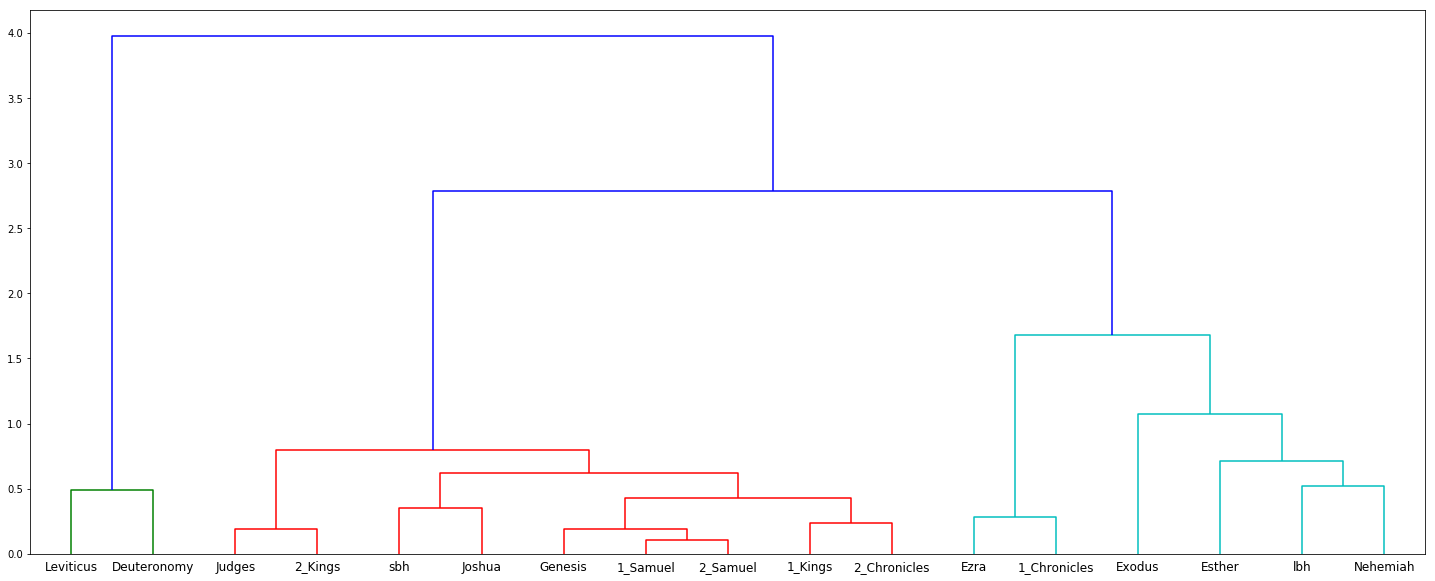

In [199]:
hierarchical_clustering(np.matrix(df_Score.values), "ward")

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


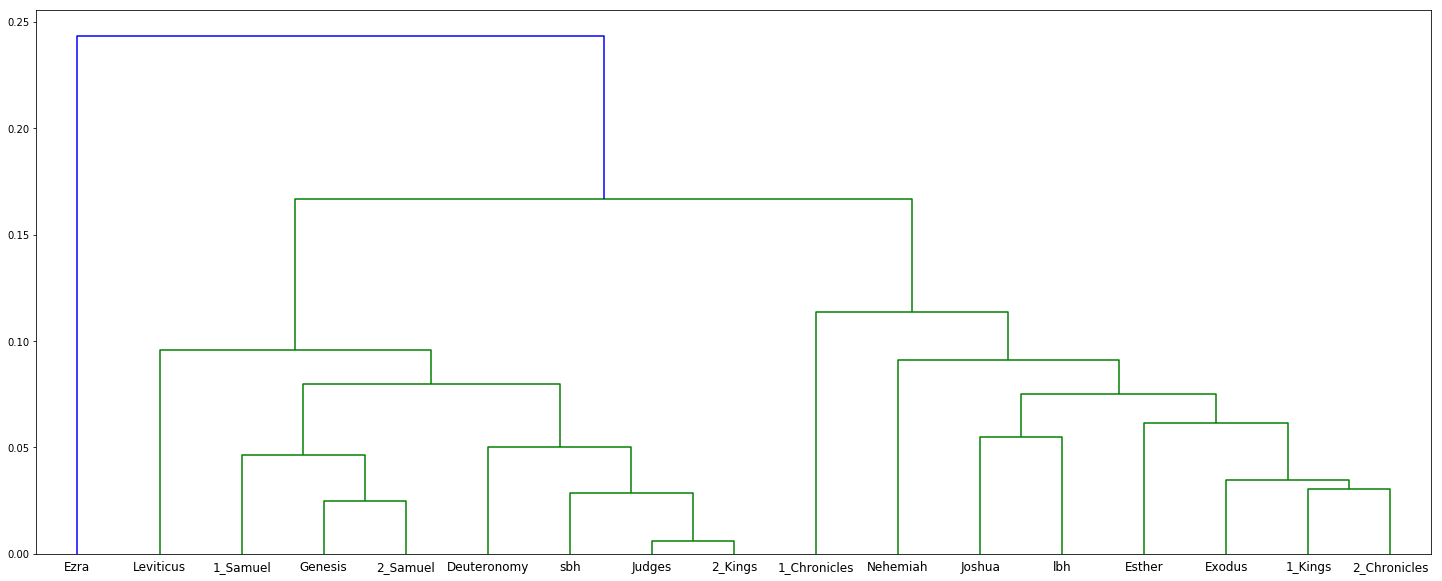

In [178]:
df_Cor = correlation_Spear(df_Count, data.keys())
hierarchical_clustering(np.matrix(df_Cor.values), "weighted")

## Part of Speech

In [180]:
data = all_data['word_pos']
unique_functions = unique(otype='word', feature='pdp') 
print(unique_functions)
df_Count, df_Prob = make_counts(data)
df_Count

['subs', 'prep', 'verb', 'conj', 'nmpr', 'art', 'nega', 'advb', 'adjv', 'prps', 'prde', 'intj', 'inrg', 'prin']


,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
adjv,168,824,108.0,14.0,39.0,74.0,70,81.0,59.0,134.0,77.0,38.0,315,32.0,73,39.0,133
advb,223,970,91.0,7.0,31.0,69.0,96,133.0,120.0,107.0,93.0,17.0,242,21.0,41,60.0,103
art,999,7325,821.0,188.0,285.0,893.0,703,800.0,710.0,1064.0,862.0,322.0,2816,206.0,533,545.0,1210
conj,3337,16807,1617.0,313.0,480.0,1630.0,1727,2105.0,1683.0,1940.0,1975.0,471.0,5654,426.0,866,1478.0,2413
inrg,2,18,0.0,0.0,1.0,0.0,2,0.0,0.0,8.0,5.0,3.0,7,0.0,1,1.0,2
intj,43,145,12.0,1.0,2.0,4.0,18,20.0,12.0,16.0,17.0,0.0,19,0.0,1,2.0,16
nega,60,539,60.0,1.0,37.0,49.0,67,65.0,40.0,75.0,85.0,16.0,168,8.0,40,21.0,83
nmpr,1914,10726,848.0,221.0,292.0,1421.0,1038,1422.0,1216.0,1151.0,1203.0,234.0,4351,459.0,578,1519.0,1561
prde,88,500,39.0,7.0,49.0,87.0,51,60.0,39.0,50.0,30.0,18.0,163,14.0,30,53.0,48
prep,2811,15979,1672.0,431.0,603.0,1707.0,1673,1812.0,1504.0,1922.0,1844.0,548.0,5649,399.0,775,1385.0,2542


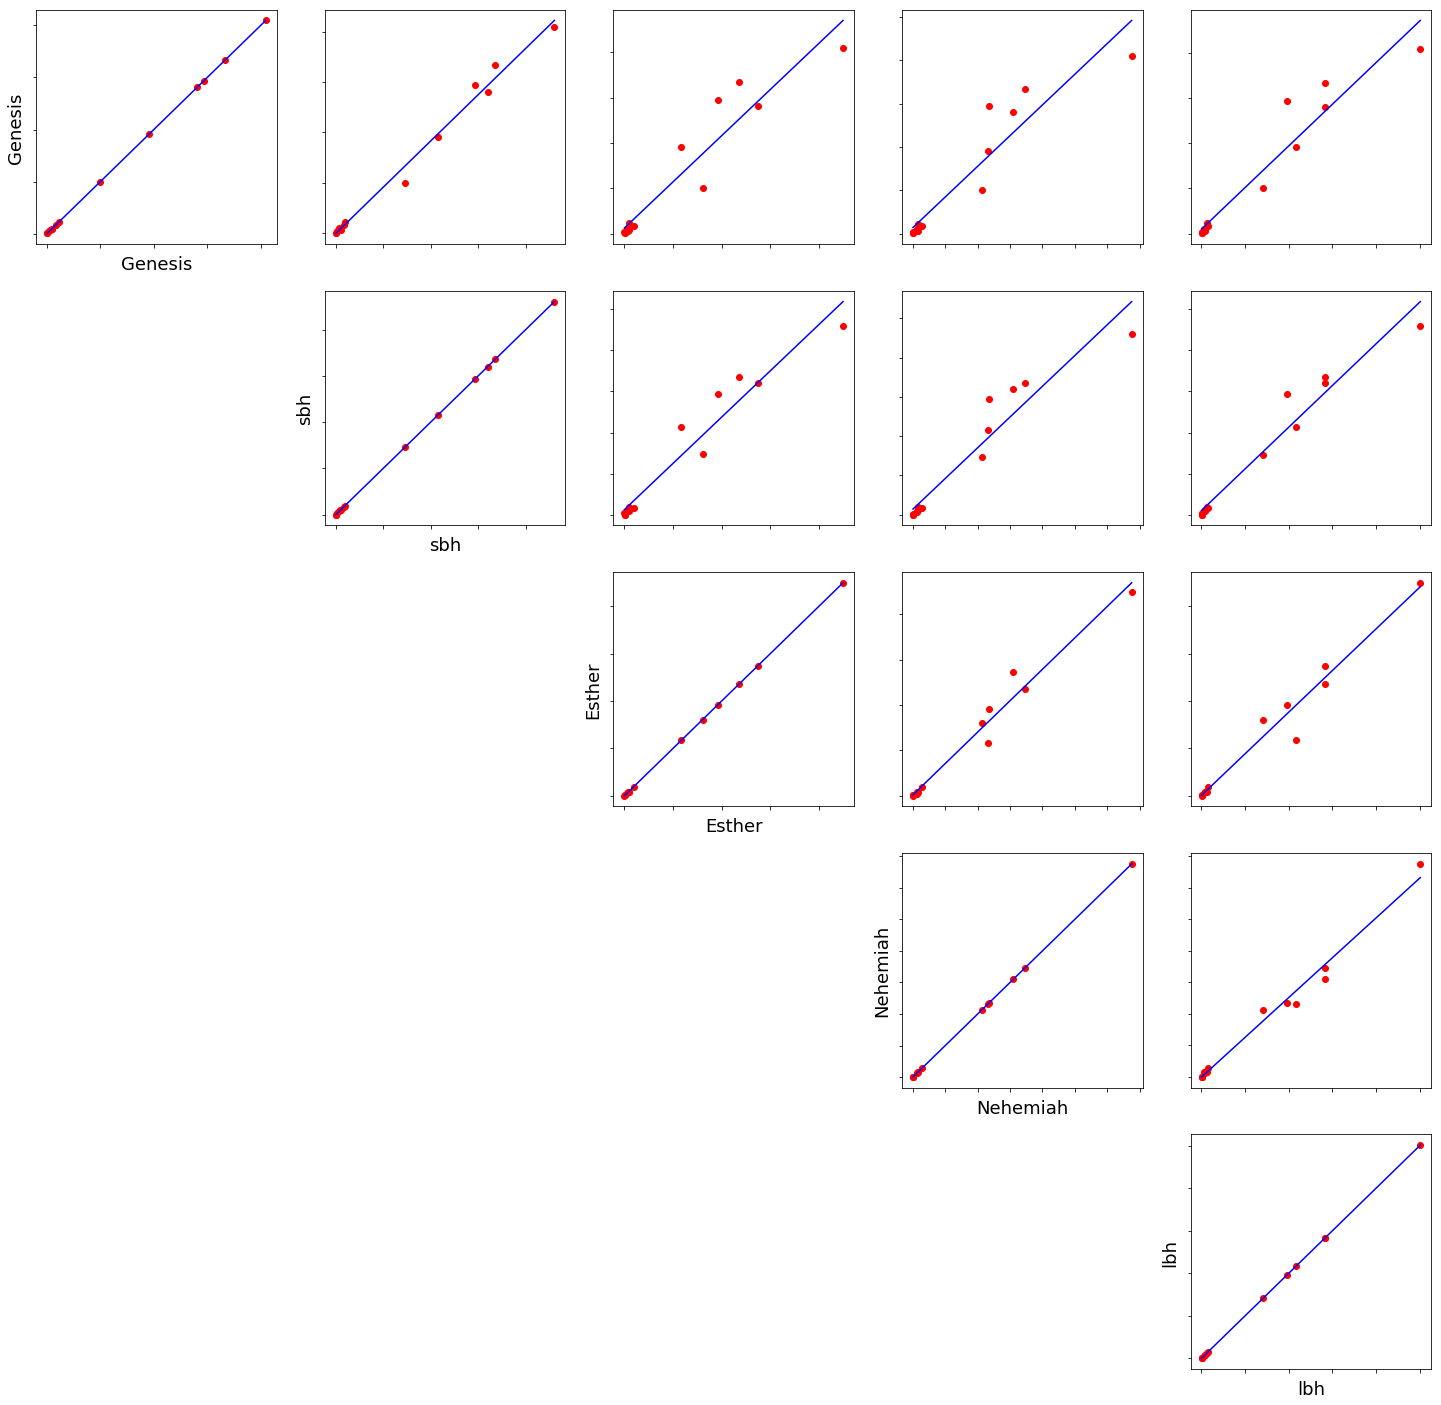

In [181]:
plot_occurences(df_Count, ["Genesis","sbh","Esther","Nehemiah", "lbh"])

In [182]:
df_MSE,df_Score, df_P = linear_model_count(df_Count,data.keys())
df_Score

,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Genesis,0.000000,0.009579,0.057102,0.080057,0.047013,0.069324,0.006123,0.011774,0.011966,0.037869,0.007143,0.097442,0.073229,0.201417,0.115132,0.104599,0.052100
sbh,0.009579,0.000000,0.031519,0.051220,0.020563,0.034947,0.002356,0.018816,0.010674,0.014033,0.002030,0.057175,0.040308,0.159136,0.075936,0.078201,0.023331
Exodus,0.057102,0.031519,0.000000,0.097162,0.029707,0.054689,0.041587,0.095370,0.075840,0.005582,0.040446,0.008758,0.020976,0.102654,0.024483,0.102852,0.005651
Leviticus,0.080057,0.051220,0.097162,0.000000,0.028072,0.060036,0.049011,0.066756,0.058831,0.074153,0.054932,0.098898,0.103683,0.255805,0.162373,0.130429,0.077434
Deuteronomy,0.047013,0.020563,0.029707,0.028072,0.000000,0.049872,0.021254,0.058760,0.046659,0.019699,0.023859,0.034760,0.054464,0.184796,0.085786,0.119396,0.026976
Joshua,0.069324,0.034947,0.054689,0.060036,0.049872,0.000000,0.051655,0.070895,0.049174,0.038369,0.050845,0.065867,0.018652,0.092552,0.056906,0.021647,0.026541
Judges,0.006123,0.002356,0.041587,0.049011,0.021254,0.051655,0.000000,0.013942,0.010092,0.022738,0.000908,0.070002,0.059521,0.192411,0.099520,0.100353,0.035995
1_Samuel,0.011774,0.018816,0.095370,0.066756,0.058760,0.070895,0.013942,0.000000,0.002778,0.062007,0.013568,0.134490,0.100591,0.242727,0.154496,0.109854,0.080965
2_Samuel,0.011966,0.010674,0.075840,0.058831,0.046659,0.049174,0.010092,0.002778,0.000000,0.045131,0.008850,0.110481,0.074869,0.204467,0.124527,0.085907,0.059949
1_Kings,0.037869,0.014033,0.005582,0.074153,0.019699,0.038369,0.022738,0.062007,0.045131,0.000000,0.020125,0.017406,0.020796,0.116230,0.032585,0.088668,0.005786


C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


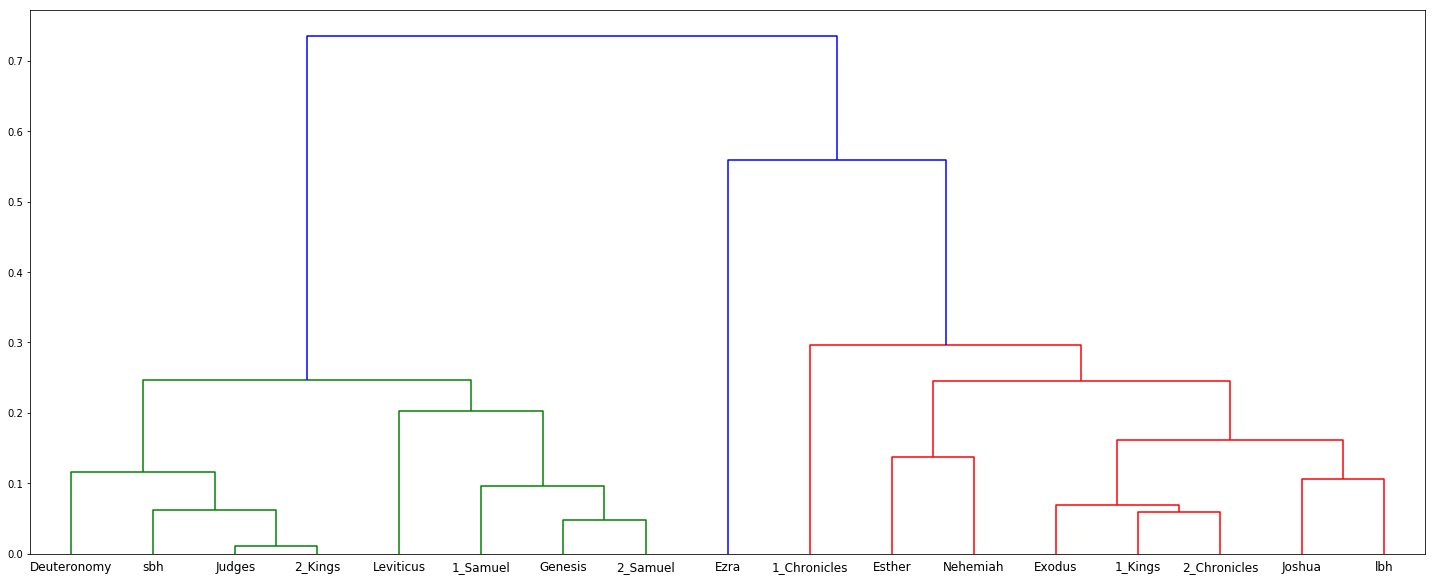

In [183]:
hierarchical_clustering(np.matrix(df_Score.values), "ward")

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


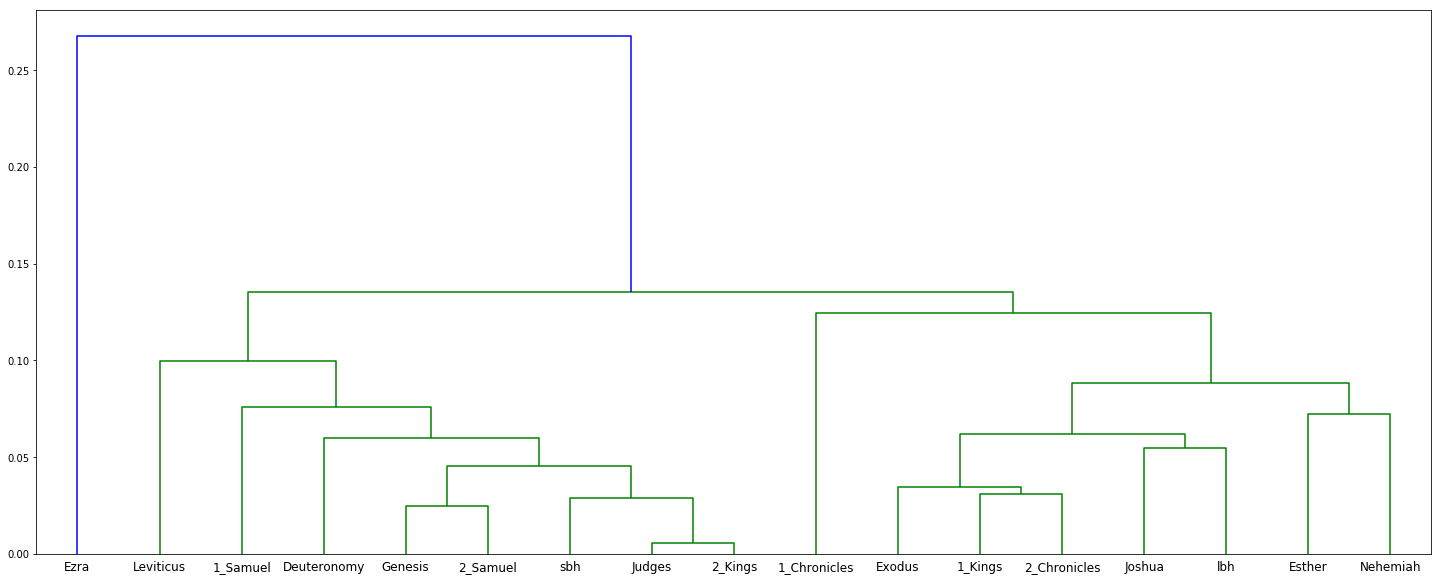

In [187]:
df_Cor = correlation_Spear(df_Count, data.keys())
hierarchical_clustering(np.matrix(df_Cor.values), "average")